In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import refnis_to_arrondissment, get_arrondissement_from_code, prov_to_region
from utils import arrond_to_prov, get_ref_df
from place_name_mappings import col_names

from sklearn.impute import SimpleImputer 

pd.set_option('display.max_colwidth', 200)
pd.set_option("display.precision", 2)

In [13]:
excell_file = "FR_immo_statbel_trimestre_par_commune.xlsx"
sheet       = "Par commune"
df          = get_ref_df(excell_file,sheet)

df["arrond"]         = df.refnis.apply(refnis_to_arrondissment)
df["arrondissement"] = df.arrond.apply(get_arrondissement_from_code)
df["province"]       = df.arrond.apply(arrond_to_prov)
df["region"]         = df.province.map(prov_to_region)

df.drop(["n_0","q1_0", "q2_0", "q3_0"],axis=1, inplace=True)


In [14]:
df.head()

,refnis,commune,year,period,n_1,q2_1,q1_1,q3_1,n_2,q2_2,q1_2,q3_2,n_3,q2_3,q1_3,q3_3,arrond,arrondissement,province,region
0,11001,AARTSELAAR,2010,Q1,25,247000,220000,265000,4,NaN,NaN,NaN,9,NaN,NaN,NaN,11,ARRONDISSEMENT D'ANVERS,10000,02000
1,11001,AARTSELAAR,2010,Q2,20,251250,209000,275000,5,NaN,NaN,NaN,11,NaN,NaN,NaN,11,ARRONDISSEMENT D'ANVERS,10000,02000
2,11001,AARTSELAAR,2010,Q3,18,250000,230000,275000,3,NaN,NaN,NaN,9,NaN,NaN,NaN,11,ARRONDISSEMENT D'ANVERS,10000,02000
3,11001,AARTSELAAR,2010,Q4,21,245000,205000,280000,7,NaN,NaN,NaN,13,NaN,NaN,NaN,11,ARRONDISSEMENT D'ANVERS,10000,02000
4,11001,AARTSELAAR,2011,Q1,18,280000,220000,360000,5,NaN,NaN,NaN,10,NaN,NaN,NaN,11,ARRONDISSEMENT D'ANVERS,10000,02000


In [15]:
def get_quarter_time(row):
    return row.year + {"Q1":0.0, "Q2":0.25,"Q3":0.5,"Q4":0.75}[row.period]

df["time"] = df[["year", "period"]].apply(get_quarter_time,axis=1)

In [18]:
def plot_agg_vs_time(df, col, time_cat, geo_name, ax):
    if geo_name in df.commune.drop_duplicates().to_list():
        df = df.loc[df.commune==geo_name, ["time", col]].dropna().copy()
        ax.plot(df.time,df[col],marker="o", label=geo_name)
        ax.set_xlabel("year")
        ax.set_ylabel(col_names[col])
        ax.set_title(geo_name)

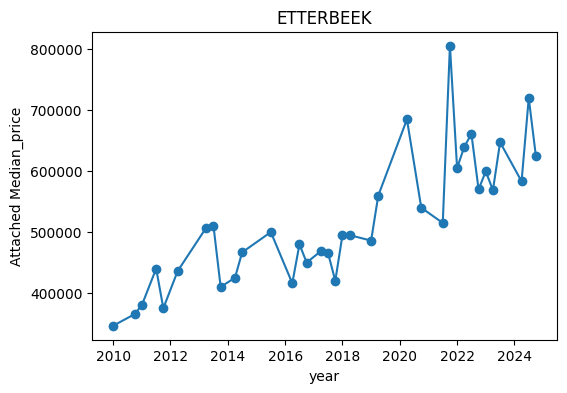

In [20]:
fig, ax = plt.subplots(figsize=(6,4))  # create figure and axis

plot_agg_vs_time(df, "q2_1", "fart", "ETTERBEEK", ax)